# Insper - Pós Graduação em Ciência de Dados

## Computação para Ciência de Dados

### Projeto Integrador - Label Engineering

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Leitura da base de dados "cs_bisnode_panel.csv"
df = pd.read_csv('cs_bisnode_panel.csv')

In [4]:
df[['comp_id']].drop_duplicates()

,comp_id
0,1.001034e+06
11,1.001541e+06
18,1.002029e+06
28,1.003200e+06
36,1.004012e+06
...,...
287794,4.640446e+11
287803,4.640568e+11
287806,4.640793e+11
287807,4.641050e+11


In [55]:
# Remoção das linhas referentes ao ano de 2016
df = df.loc[df['year'] != 2016]

In [56]:
# Criando uma nova tabela com index reestabelecido
df_reindex = df.set_index(['year', 'comp_id'])

In [57]:
# Salvando os index em um objeto separado
index = pd.MultiIndex.from_product(df_reindex.index.levels)

In [58]:
# Reindexação da tabela df_reindex utilizando o objeto "index".
# Preenchendo os campos "NA" com 0 e ordenando a tabela por "comp_id" e "year", respectivamente
tb02 = df_reindex.reindex(index).reset_index().sort_values(by= ['comp_id', 'year'], ascending=True)

In [59]:
# Criando uma coluna chamada "status_alive" para indicar as empresas que estão em operação
tb02['status_alive'] = np.where(tb02['sales'] == 0, 0, 1)

In [60]:
# Criando duas colunas "shift1" e "shift2" para indicar quais empresas irão falir dois anos após um determinado ano
# Coluna "shift1" - Importante realizar o group by antes de realizar o shift para que este ocorra levando em consideração mesmas empresas
tb02['shift1'] = tb02['status_alive']
tb02['shift1'] = tb02.groupby('comp_id')['shift1'].shift(periods=-1, fill_value=7)
# Coluna "shift2" - Importante realizar o group by antes de realizar o shift para que este ocorra levando em consideração mesmas empresas
#tb02['shift2'] = tb02['status_alive']
#tb02['shift2'] = tb02.groupby('comp_id')['shift2'].shift(periods=-2, fill_value=7)
# Coluna "default"
tb02['default'] = tb02['status_alive'] - tb02['shift1'] #- tb02['shift2']
# Reescrevendo a coluna deafult de forma que ela indique 1 nos casos em que houve default em 2 anos e 0 nos casos em que não houve default em 2 anos
tb02['default'] = np.where(tb02['default'] == 1, 1, 0)

In [61]:
# Transformando "comp_id" de númerico para character
tb02['comp_id'] = tb02['comp_id'].apply(lambda x:str(int(x))) 

In [62]:
# Calculando o primeiro ano que cada empresa apresentou vendas
df = df.reset_index()
df['comp_id'] = df['comp_id'].apply(lambda x:str(int(x)))
tb_first_year_sales = df[['comp_id', 'year']].groupby('comp_id').min().reset_index()
tb_first_year_sales = tb_first_year_sales.rename(columns={'year':'first_year'})

# Removendo os anos anteriores ao primeiro ano de venda de cada empresa
tb03 = pd.merge(tb02, tb_first_year_sales, how='left', on = ['comp_id'])
tb03['remove'] = np.where(tb03['year']<tb03['first_year'], 1, 0)
tb04 = tb03.loc[tb03['remove'] == 0]

In [63]:
# Remover colunas de suporte
tb04 = tb04.drop(columns=['shift1', 'remove', 'first_year'], axis = 0)

In [64]:
# Selecionando anos inferiores ou iguais a 2012
tb04 = tb04.loc[tb04['year'] <= 2012]

In [65]:
# Buscando por colunas com grande quantidade de valores faltantes.
# Usando a tabela original "df" para verificar quais colunas possuem grande percentual de valores faltantes
tb_missing = pd.DataFrame(df.isna().sum()).reset_index().rename(columns={'index':'features', 0:'value'})

# Calculando a fração de valores faltantes
tb_missing['ratio'] = tb_missing['value'] / len(df)

# Ordenando de forma decrescente em função da proporção de valores faltantes
tb_missing = tb_missing.sort_values(by='ratio', ascending=False)

## Codificando Variáveis Categoricas

In [66]:
# Codficando a variável "region_m"
dt_region = {'West':1, 'East':2, 'Central':3, 0:0}
for m in dt_region:
    tb04.loc[tb04['region_m']==m,'region_m'] = dt_region[m]

In [67]:
# Codficando a variável "origin"
dt_origin = {'Domestic':1, 'Foreign':2, 'mix':3, 0:0}
for o in dt_origin:
    tb04.loc[tb04['origin']==o,'origin'] = dt_origin[o]

## Removendo Variáveis

In [68]:
# Se considerarmos que a "feature" deve possuir um percentual de valores faltantes inferior a 10% iremos remover as 17 primeiras features
remover_features = list(tb_missing.loc[tb_missing['ratio'] > 0.4]['features'])

In [69]:
# Remoção de variáveis com grande percentual de valores faltantes
tb04 = tb04.drop(columns=remover_features, axis = 0)

In [70]:
# Criando função sigmoidal de apoio
def sigmoid(x):
    """
    Resumo: Recebe x e devolve sigmoid(x).
    Entradas:
        x - Valor de interesse                                                          | tipo: float
    Saídas:
        sigmoid(x)
    """
    return x/(1 + abs(x))

## Corrigindo Variáveis e Realizando Cálculos Adicionais

In [71]:
def adjusting_variables(table, variable):

    """
    Resumo: Ajusta os valores de uma variável de interesse:
            - Coloca zero caso seja nulo;
            - Coloca zero caso seja negativo;
            - Calcula o log;
            - Calcula o log ao quadrado;
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        variable - Variável que será utilizada para cálculo do crescimento relativo     | tipo: string
    Saídas:
        table - Dataframe de entrada contendo três novas colunas: "variable" ajustada, log "variable", log2 "variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria uma coluna flag para indicar os casos em que var_t-1 é nulo / zero
    table['flag_'+variable] = np.where((table[variable] < 0) | (table[variable].isnull()==True), 1, 0)

    # Corrige a coluna de interesse
    table[variable] = np.where((table[variable] < 0) | (table[variable].isnull()==True), 0, table[variable])

    # Calcula o log da variável de interesse
    table['log_'+variable] = table[variable].apply(lambda x:np.log(x+1))

    # Calcula o quadrado do log da variável de interesse
    table['log_sqr_'+variable] = table['log_'+variable].apply(lambda x:x**2)

    return table.reset_index(drop=True)

tb04 = adjusting_variables(table=tb04, variable='curr_assets')
tb04 = adjusting_variables(table=tb04, variable='curr_liab')
tb04 = adjusting_variables(table=tb04, variable='inventories')
tb04 = adjusting_variables(table=tb04, variable='sales')
tb04 = adjusting_variables(table=tb04, variable='fixed_assets')
tb04 = adjusting_variables(table=tb04, variable='liq_assets')
tb04 = adjusting_variables(table=tb04, variable='intang_assets')
tb04 = adjusting_variables(table=tb04, variable='tang_assets')
tb04 = adjusting_variables(table=tb04, variable='extra_inc')
tb04 = adjusting_variables(table=tb04, variable='extra_exp')
tb04 = adjusting_variables(table=tb04, variable='material_exp')
tb04 = adjusting_variables(table=tb04, variable='amort')
tb04 = adjusting_variables(table=tb04, variable='personnel_exp')
tb04 = adjusting_variables(table=tb04, variable='share_eq')
tb04 = adjusting_variables(table=tb04, variable='subscribed_cap')
tb04 = adjusting_variables(table=tb04, variable='inoffice_days')


## Cálculando Crescimento Relativo para Algumas Variáveis

In [72]:
# Função para calcular o crescimento das vendas de um ano para outro
def calculate_sales_growth(table, variable, shift_period_start, shift_period_end, new_variable):

    """
    Resumo: Calcula o crescimento relativo de uma variável de interesse.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        variable - Variável que será utilizada para cálculo do crescimento relativo     | tipo: string
        shift_period_start - Início do intervalo de tempo                               | tipo: integer
        shift_period_end - Final do intervalo de tempo                                  | tipo: integer
        new_variable - Nome da variável que será criada                                 | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: "new_variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria dois vetores de suporte a partir do "shift" da coluna de interesse
    support_vector_end   = table.groupby('comp_id')[variable].shift(periods = shift_period_end,   fill_value = 0)
    support_vector_start = table.groupby('comp_id')[variable].shift(periods = shift_period_start, fill_value = 0)

    # Calcula a variação relativa da variável de interesse ao longo do tempo: (var_t - var_t-1) / (var_t-1)
    table[new_variable] = np.where(support_vector_start == 0, 0, (support_vector_end - support_vector_start)/ support_vector_start)

    # Retorna o o crescimento como um valor entre [-1;1]
    table[new_variable] = table[new_variable].apply(lambda x:sigmoid(x))

    # Cria uma coluna flag para indicar os casos em que var_t-1 é nulo / zero
    table['flag_'+new_variable] = np.where(support_vector_start == 0 , 1, 0)

    return table.reset_index(drop=True)

# Cálculo do crescimento das vendas de 2011 para 2012
tb04 = calculate_sales_growth(table=tb04, variable='sales', shift_period_start=1, shift_period_end=0, new_variable='sig_growth_sales_2012_2011')
# Cálculo do crescimento das vendas de 2010 para 2011
tb04 = calculate_sales_growth(table=tb04, variable='sales', shift_period_start=2, shift_period_end=1, new_variable='sig_growth_sales_2011_2010')
# Cálculo do crescimento da receita antes dos impostos de 2011 para 2012
tb04 = calculate_sales_growth(table=tb04, variable='inc_bef_tax', shift_period_start=1, shift_period_end=0, new_variable='sig_growth_inc_bef_tax_2012_2011')
# Cálculo do crescimento da receita antes dos impostos de 2010 para 2011
tb04 = calculate_sales_growth(table=tb04, variable='inc_bef_tax', shift_period_start=2, shift_period_end=1, new_variable='sig_growth_inc_bef_tax_2011_2010')

## Calculando Idade da Empresa e Idade Média dos CEOs

In [73]:
# Calculando a idade das empresas
tb04['company_age'] =  np.where((tb04['founded_year'].isnull() == True) | (tb04['founded_year'] == 0), 0, tb04['year'] - tb04['founded_year'])
tb04['company_age'] =  np.where(tb04['company_age'] < 0, 0, tb04['company_age'])
tb04['flag_company_age'] = np.where(tb04['company_age'] < 0, 0, 1)
tb04['company_age'] = tb04['company_age'] + 1

# Calculando a idade média dos CEOs
tb04['ceos_age'] =  np.where((tb04['birth_year'].isnull() == True) | (tb04['birth_year'] == 0), 0, tb04['year'] - tb04['birth_year'])
tb04['ceos_age'] =  np.where(tb04['ceos_age'] < 18, 0, tb04['ceos_age'])
tb04['flag_ceos_age'] = np.where(tb04['ceos_age'] < 18, 0, 1)

## Calculando indicadores financeiros

### Quick Ratio

In [74]:
def quick_ratio(table, shift_period, new_variable):

    """
    Resumo: Calcula uma medida de liquidez da empresa.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        shift_period - Início do intervalo de tempo                                     | tipo: integer
        new_variable - Nome da variável que será criada                                 | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: "new_variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria dois vetores de suporte a partir do "shift" da coluna de interesse
    sv_current_liab    = table.groupby('comp_id')['curr_liab'].shift(periods = shift_period, fill_value = 0)
    sv_current_assets  = table.groupby('comp_id')['curr_assets'].shift(periods = shift_period, fill_value = 0)
    sv_current_invent  = table.groupby('comp_id')['inventories'].shift(periods = shift_period, fill_value = 0)

    # Calcula a medida de liquidez
    table[new_variable] = np.where(sv_current_liab == 0, 0, (sv_current_assets - sv_current_invent) / sv_current_liab)

    # Retorna o o crescimento como um valor entre [-1;1]
    table[new_variable] = table[new_variable].apply(lambda x:sigmoid(x))

    # Cria uma flag onde o cálculo apresenta problema
    table['flag_'+new_variable] = np.where(sv_current_liab == 0, 1, 0)

    return table.reset_index(drop=True)

# Cálculo do "quick ratio" para os anos de 2012, 2011 e 2010
tb04 = quick_ratio(table=tb04, shift_period=0, new_variable='sig_quick_ratio_2012')
tb04 = quick_ratio(table=tb04, shift_period=1, new_variable='sig_quick_ratio_2011')
tb04 = quick_ratio(table=tb04, shift_period=2, new_variable='sig_quick_ratio_2010')

### Working Capital Ratio

In [75]:
def working_capital_ratio(table, shift_period, new_variable):

    """
    Resumo: Calcula uma medida da capacidade da empresa de pagar suas dívidas.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        shift_period - Início do intervalo de tempo                                     | tipo: integer
        new_variable - Nome da variável que será criada                                 | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: "new_variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria dois vetores de suporte a partir do "shift" da coluna de interesse
    sv_current_liab    = table.groupby('comp_id')['curr_liab'].shift(periods = shift_period, fill_value = 0)
    sv_current_assets  = table.groupby('comp_id')['curr_assets'].shift(periods = shift_period, fill_value = 0)

    # Calcula a medida de liquidez
    table[new_variable] = np.where(sv_current_liab == 0, 0, sv_current_assets / sv_current_liab)

    # Retorna o o crescimento como um valor entre [-1;1]
    table[new_variable] = table[new_variable].apply(lambda x:sigmoid(x))

    # Cria uma flag onde o cálculo apresenta problema
    table['flag_'+new_variable] = np.where(sv_current_liab == 0, 1, 0)

    return table.reset_index(drop=True)

# Cálculo do "working_capital_ratio" para os anos de 2012, 2011 e 2010
tb04 = working_capital_ratio(table=tb04, shift_period=0, new_variable='sig_working_capital_ratio_2012')
tb04 = working_capital_ratio(table=tb04, shift_period=1, new_variable='sig_working_capital_ratio_2011')
tb04 = working_capital_ratio(table=tb04, shift_period=2, new_variable='sig_working_capital_ratio_2010')

### Profit Margin

In [76]:
def profit_margin(table, shift_period, new_variable):

    """
    Resumo: Calcula uma medida da capacidade de gerar lucro em relação ao volume de vendas.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        shift_period - Início do intervalo de tempo                                     | tipo: integer
        new_variable - Nome da variável que será criada                                 | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: "new_variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria dois vetores de suporte a partir do "shift" da coluna de interesse
    sv_profit  = table.groupby('comp_id')['profit_loss_year'].shift(periods = shift_period, fill_value = 0)
    sv_sales   = table.groupby('comp_id')['sales'].shift(periods = shift_period, fill_value = 0)

    # Calcula a medida de liquidez
    table[new_variable] = np.where(sv_sales == 0, 0, sv_profit / sv_sales)

    # Retorna o o crescimento como um valor entre [-1;1]
    table[new_variable] = table[new_variable].apply(lambda x:sigmoid(x))

    # Cria uma flag onde o cálculo apresenta problema
    table['flag_'+new_variable] = np.where(sv_sales == 0, 1, 0)

    return table.reset_index(drop=True)

# Cálculo do "profit_margin" para os anos de 2012, 2011 e 2010
tb04 = profit_margin(table=tb04, shift_period=0, new_variable='sig_profit_margin_2012')
tb04 = profit_margin(table=tb04, shift_period=1, new_variable='sig_profit_margin_2011')
tb04 = profit_margin(table=tb04, shift_period=2, new_variable='sig_profit_margin_2010')

### EBITDA Margin

In [77]:
def ebitda_margin(table, shift_period, new_variable):

    """
    Resumo: Calcula uma medida da capacidade de gerar lucro em relação ao volume de vendas.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        shift_period - Início do intervalo de tempo                                     | tipo: integer
        new_variable - Nome da variável que será criada                                 | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: "new_variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria dois vetores de suporte a partir do "shift" da coluna de interesse
    sv_ebitda  = table.groupby('comp_id')['inc_bef_tax'].shift(periods = shift_period, fill_value = 0)
    sv_sales   = table.groupby('comp_id')['sales'].shift(periods = shift_period, fill_value = 0)

    # Calcula a medida de liquidez
    table[new_variable] = np.where(sv_sales == 0, 0, sv_ebitda / sv_sales)

    # Retorna o o crescimento como um valor entre [-1;1]
    table[new_variable] = table[new_variable].apply(lambda x:sigmoid(x))

    # Cria uma flag onde o cálculo apresenta problema
    table['flag_'+new_variable] = np.where(sv_sales == 0, 1, 0)

    return table.reset_index(drop=True)

# Cálculo do "profit_margin" para os anos de 2012, 2011 e 2010
tb04 = ebitda_margin(table=tb04, shift_period=0, new_variable='sig_inc_bef_tax_margin_2012')
tb04 = ebitda_margin(table=tb04, shift_period=1, new_variable='sig_inc_bef_tax_margin_2011')
tb04 = ebitda_margin(table=tb04, shift_period=2, new_variable='sig_inc_bef_tax_margin_2010')

### Extra Profit Margin

In [78]:
def extra_profit_margin(table, shift_period, new_variable):

    """
    Resumo: Calcula a margem de geração de lucro extra.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        shift_period - Início do intervalo de tempo                                     | tipo: integer
        new_variable - Nome da variável que será criada                                 | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: "new_variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria dois vetores de suporte a partir do "shift" da coluna de interesse
    sv_profit    = table.groupby('comp_id')['extra_profit_loss'].shift(periods = shift_period, fill_value = 0)
    sv_sales  = table.groupby('comp_id')['sales'].shift(periods = shift_period, fill_value = 0)

    # Calcula a medida de liquidez
    table[new_variable] = np.where(sv_sales == 0, 0, sv_profit / sv_sales)

    # Retorna o o crescimento como um valor entre [-1;1]
    table[new_variable] = table[new_variable].apply(lambda x:sigmoid(x))

    # Cria uma flag onde o cálculo apresenta problema
    table['flag_'+new_variable] = np.where(sv_sales == 0, 1, 0)

    return table.reset_index(drop=True)

# Cálculo do "profit_margin" para os anos de 2012, 2011 e 2010
tb04 = extra_profit_margin(table=tb04, shift_period=0, new_variable='sig_extra_profit_margin_2012')
tb04 = extra_profit_margin(table=tb04, shift_period=1, new_variable='sig_extra_profit_margin_2011')
tb04 = extra_profit_margin(table=tb04, shift_period=2, new_variable='sig_extra_profit_margin_2010')

### Return on Equity

In [79]:
def return_on_equity(table, shift_period, new_variable):

    """
    Resumo: Calcula uma medida da capacidade de gerar lucro por equity.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        shift_period - Início do intervalo de tempo                                     | tipo: integer
        new_variable - Nome da variável que será criada                                 | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: "new_variable" e "flag_new_variable". 
                Esta última indica casos onde há problemas no cálculo de "new_variable".
    """

    # Cria dois vetores de suporte a partir do "shift" da coluna de interesse
    sv_profit    = table.groupby('comp_id')['profit_loss_year'].shift(periods = shift_period, fill_value = 0)
    sv_equity  = table.groupby('comp_id')['share_eq'].shift(periods = shift_period, fill_value = 0)

    # Calcula a medida de liquidez
    table[new_variable] = np.where(sv_equity == 0, 0, sv_profit / sv_equity)

    # Retorna o o crescimento como um valor entre [-1;1]
    table[new_variable] = table[new_variable].apply(lambda x:sigmoid(x))

    # Cria uma flag onde o cálculo apresenta problema
    table['flag_'+new_variable] = np.where(sv_equity == 0, 1, 0)

    return table.reset_index(drop=True)

# Cálculo do "profit_margin" para os anos de 2012, 2011 e 2010
tb04 = return_on_equity(table=tb04, shift_period=0, new_variable='sig_return_on_equity_2012')
tb04 = return_on_equity(table=tb04, shift_period=1, new_variable='sig_return_on_equity_2011')
tb04 = return_on_equity(table=tb04, shift_period=2, new_variable='sig_return_on_equity_2010')

## Selecionando Ano de Interesse

In [80]:
# Selecionando o ano de 2012
tb2012 = tb04.loc[tb04['year']==2012]

## Defininfo Faixa de Vendas

In [81]:
# Empresas com vendas menores que 1000 euros serão consideradas como inativas e portanto terão seus valores de vendas zerados
# Também serão desconsideradas as empresas com faturamento superior a 10 milhões
tb2012 = tb2012.loc[(tb2012['sales']>1000) & (tb2012['sales']<10*10**6)]

## Marcando Startups

In [82]:
# Marcando quais empresas são startups
tb_first_year_sales['startups'] = 1
tb2012 = pd.merge(tb2012, tb_first_year_sales.rename(columns={'first_year':'year'}), how = 'left', on = ['comp_id', 'year'])
tb2012['startups'] = np.where(tb2012['startups'].isnull()==True, 0, 1)

## Selecionando Ano de Interesse

In [83]:
# Remover a coluna ano, pois ela se torna constante após filtramos o ano de 2012
remover_ajuste = ['curr_assets', 'curr_liab', 'inventories', 'sales', 'fixed_assets', 'liq_assets', 'intang_assets', 'tang_assets', 'extra_inc', 'extra_exp', 'material_exp', 
                  'amort', 'personnel_exp', 'year', 'founded_year', 'founded_date', 'birth_year', 'gender', 'status_alive', 'share_eq', 'subscribed_cap', 'end', 'begin', 
                  'balsheet_length', 'extra_profit_loss', 'inc_bef_tax', 'profit_loss_year']
tb2012 = tb2012.drop(columns=remover_ajuste, axis = 0)
# Renomeando algumas colunas
tb2012 = tb2012.rename(columns = {'balsheet_notfullyear':'flag_balsheet_notfullyear', 'balsheet_flag':'flag_balsheet'})

## Preparando Dados para Plot

In [84]:
flag_columns = []        # Lista de colunas "flags"
financial_columns = []   # Colunas com indicadores financeiros

for column in tb2012.columns:
    if ('flag' in column):
        flag_columns.append(column)
    else:
        financial_columns.append(column)


In [85]:
# Seleciona flags constantes
remover_flag = []
for flag in flag_columns:
    if(tb2012[flag].min()==tb2012[flag].max()):
        remover_flag.append(flag)

# Remove flags constantes
tb2012 = tb2012.drop(columns=remover_flag, axis = 0)

# Flags remanescentes
flags_remaining = []
for flag in flag_columns:
    if(flag not in remover_flag):
        flags_remaining.append(flag)    

In [86]:
# Separando gráficos
features_log, max_log, min_log = [], [], []
features_logsqrt, max_logsqrt, min_logsqrt = [], [], []
features_sig, max_sig, min_sig = [], [], []
features_others = []
for item in financial_columns:
    if('log' in item and 'sqr' not in item):
        features_log.append(item)
        max_log.append(tb2012[item].max())
        min_log.append(tb2012[item].min())
    elif('log' in item and 'sqr' in item):
        features_logsqrt.append(item)
        max_logsqrt.append(tb2012[item].max())
        min_logsqrt.append(tb2012[item].min())
    elif('sig' in item):
        features_sig.append(item)
        max_sig.append(tb2012[item].max())
        min_sig.append(tb2012[item].min())
    else:
        features_others.append(item)


## Plotando Gráficos para Analisar a Distribução das Métricas Selecionadas no Dataset

Objetivo: Verificar inconsistências na distribuição das features selecionadas.

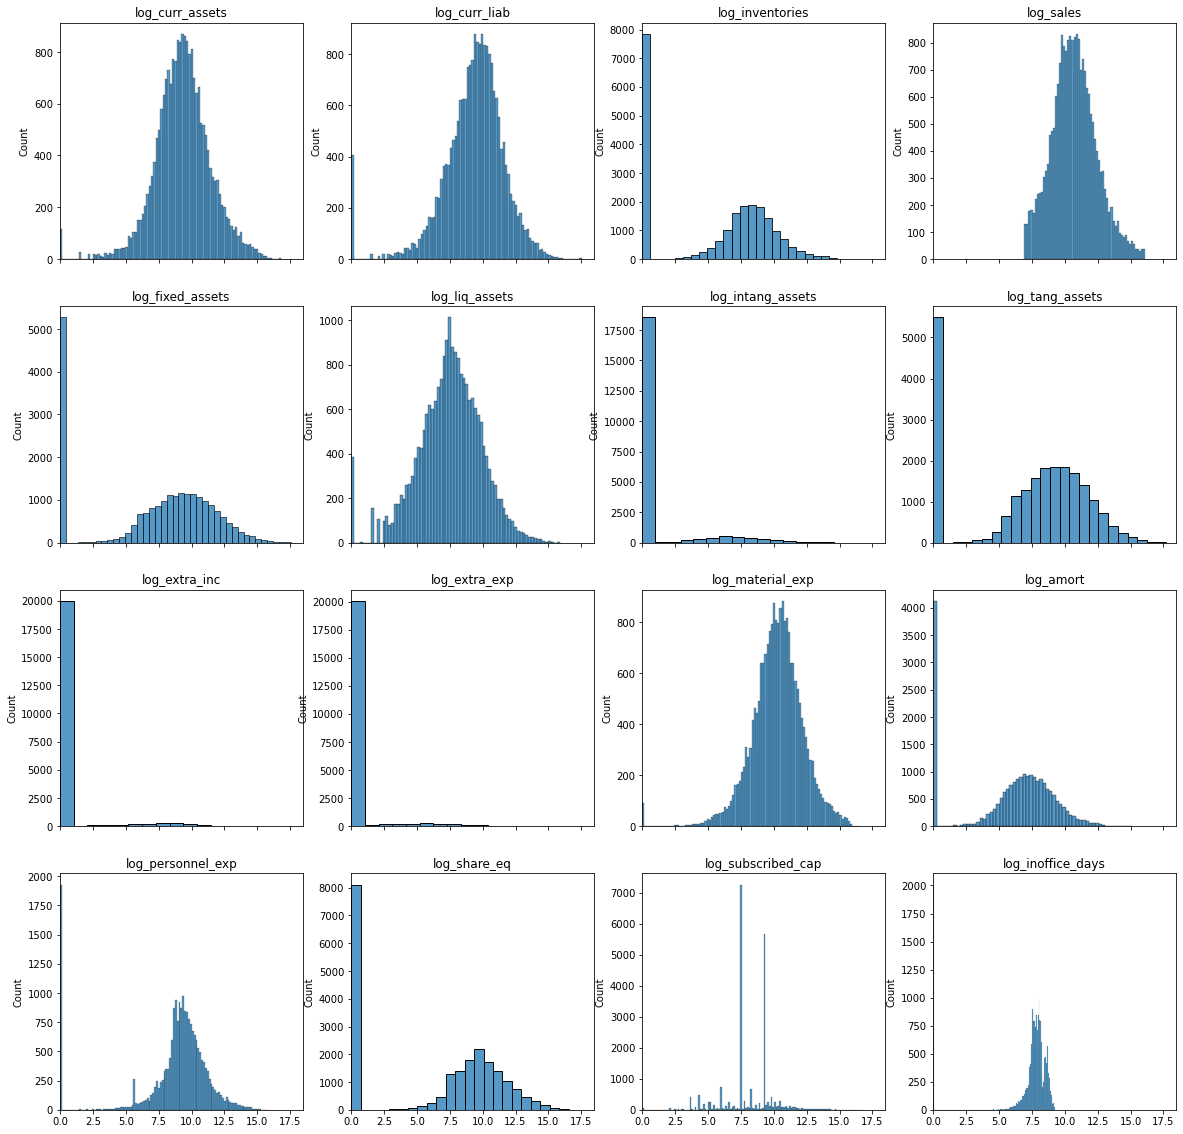

In [87]:
fig, axes = plt.subplots(4, 4, sharex=True, figsize=(20,20))
i = 0
for r in range(4):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=features_log[i]);
        axes[r, c].set_xlim([np.min(min_log), np.max(max_log)])
        axes[r, c].set_title(features_log[i])
        axes[r, c].set(xlabel=None)
        i+=1

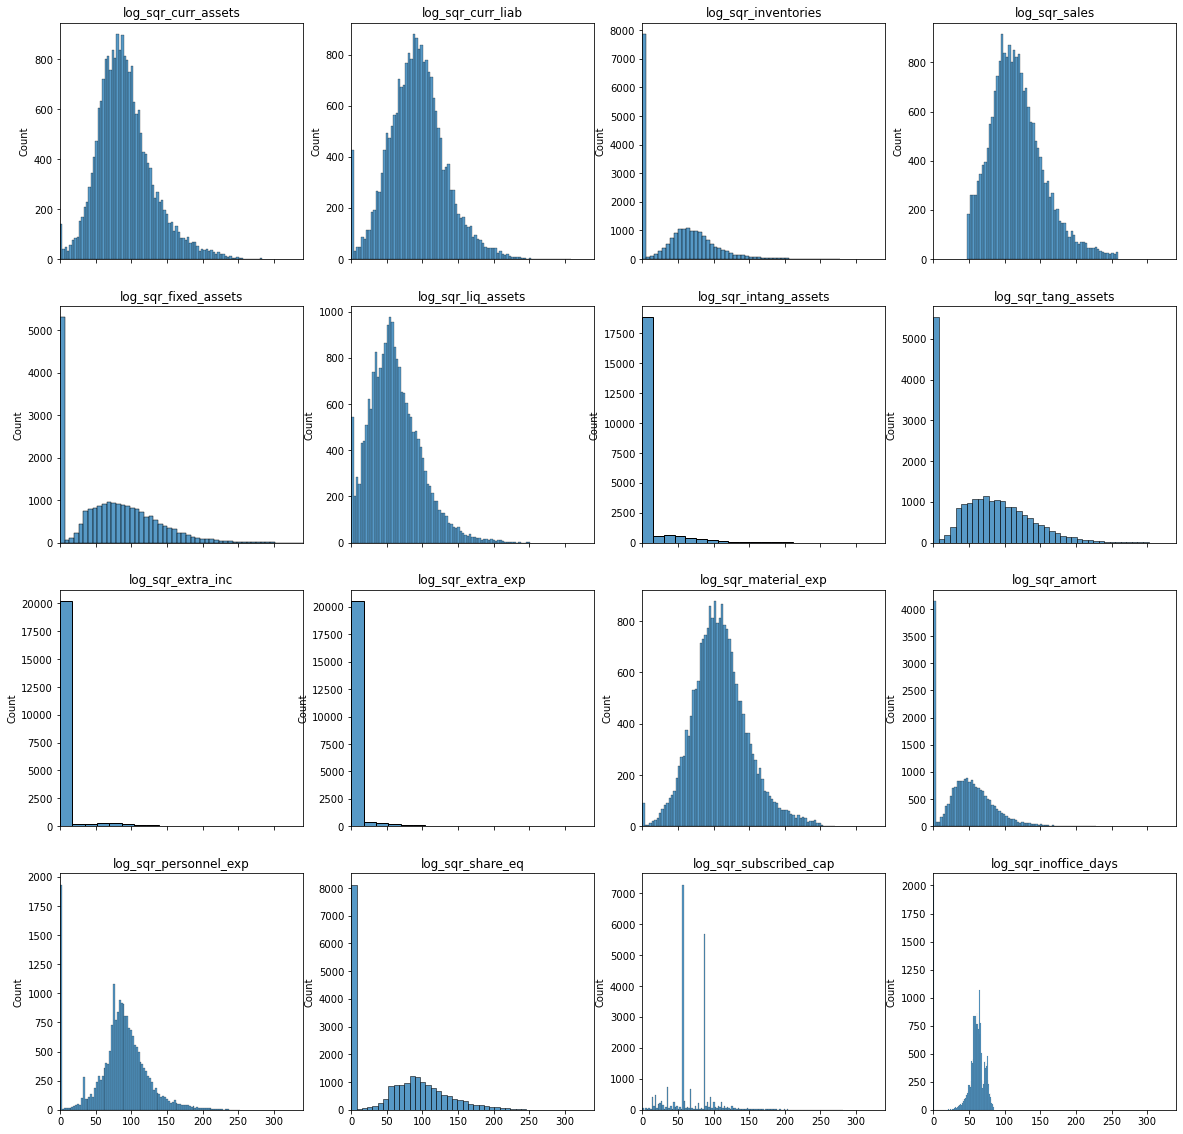

In [88]:
fig, axes = plt.subplots(4, 4, sharex=True, figsize=(20,20))
i = 0
for r in range(4):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=features_logsqrt[i]);
        axes[r, c].set_xlim([np.min(min_logsqrt), np.max(max_logsqrt)])
        axes[r, c].set_title(features_logsqrt[i])
        axes[r, c].set(xlabel=None)
        i+=1

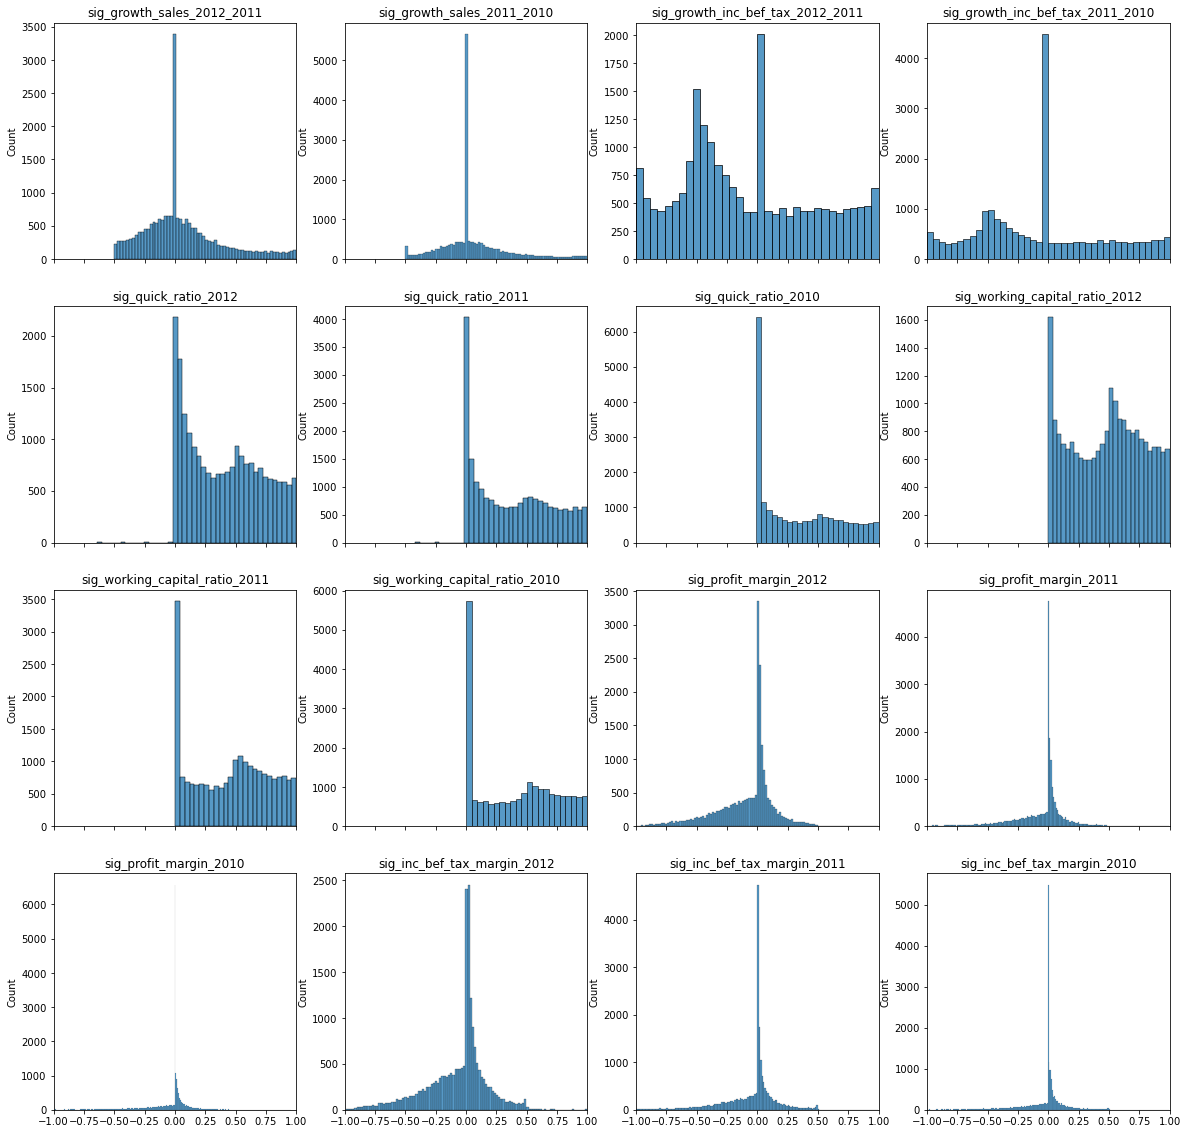

In [89]:
fig, axes = plt.subplots(4, 4, sharex=True, figsize=(20,20))
i = 0
for r in range(4):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=features_sig[i]);
        axes[r, c].set_xlim([-1,1])
        axes[r, c].set_title(features_sig[i])
        axes[r, c].set(xlabel=None)
        i+=1

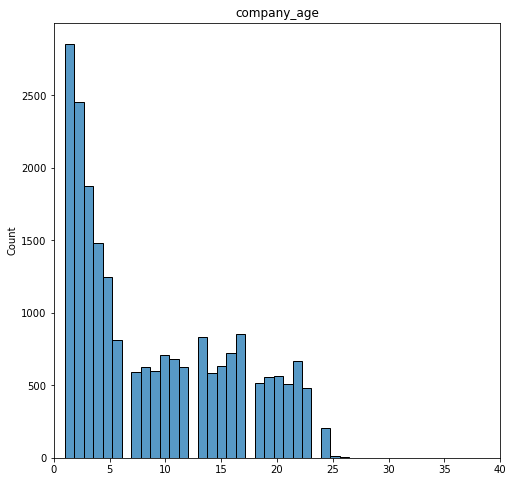

In [90]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,8))

sns.histplot(ax=ax, data=tb2012, x='company_age')
ax.set_xlim([0, 40])
ax.set_title('company_age')
ax.set(xlabel=None);

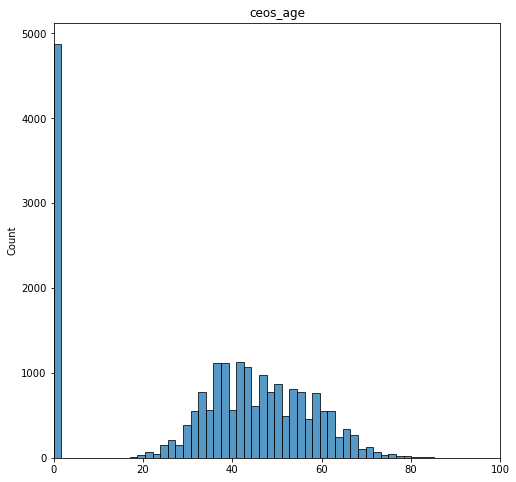

In [91]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,8))

sns.histplot(ax=ax, data=tb2012, x='ceos_age')
ax.set_xlim([0, 100])
ax.set_title('ceos_age')
ax.set(xlabel=None);

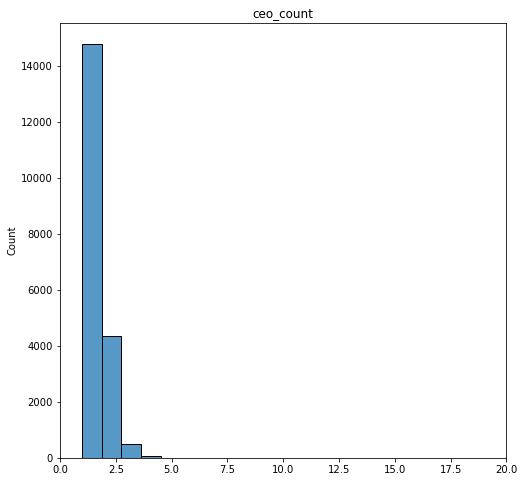

In [92]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,8))

sns.histplot(ax=ax, data=tb2012, x='ceo_count')
ax.set_xlim([0, 20])
ax.set_title('ceo_count')
ax.set(xlabel=None);

## Plotando Gráficos de Flags para Erros Identificados em Features

Objetivo: Verificar se existe alguma variável com volume exagerado de observações com problema.\
Conclusão: Aparentemente, apenas os indicadores relacionados à feature "share_eq" apresentam um grande volume de observações com problema. Por hora, essa variável será deixado no dataset.

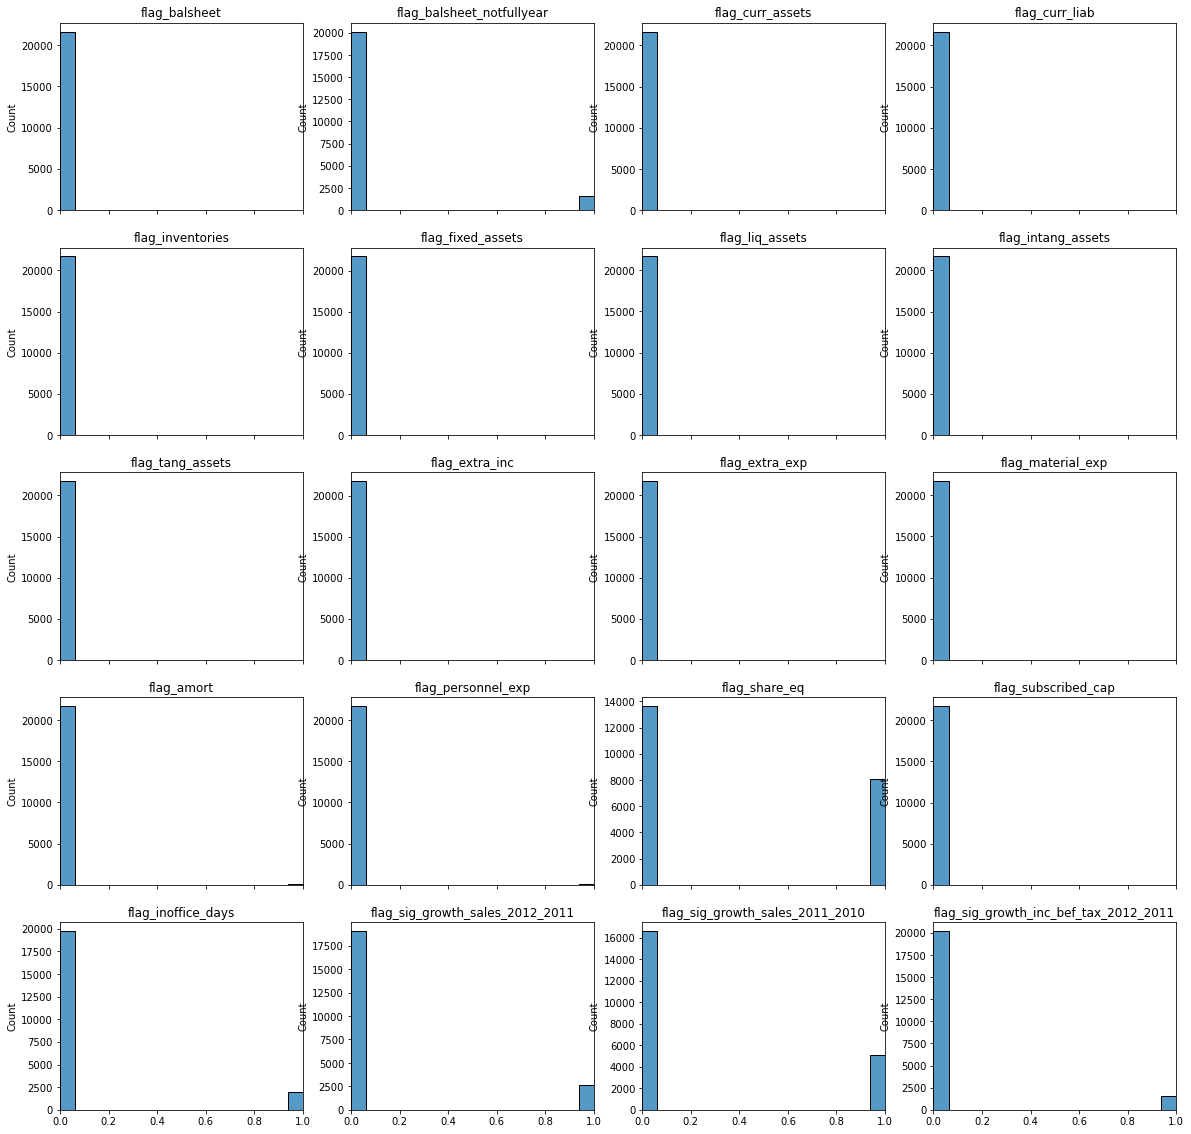

In [93]:
fig, axes = plt.subplots(5, 4, sharex=True, figsize=(20,20))
i = 0
for r in range(5):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=flags_remaining[i]);
        axes[r, c].set_xlim([0,1])
        axes[r, c].set_title(flags_remaining[i])
        axes[r, c].set(xlabel=None)
        i+=1

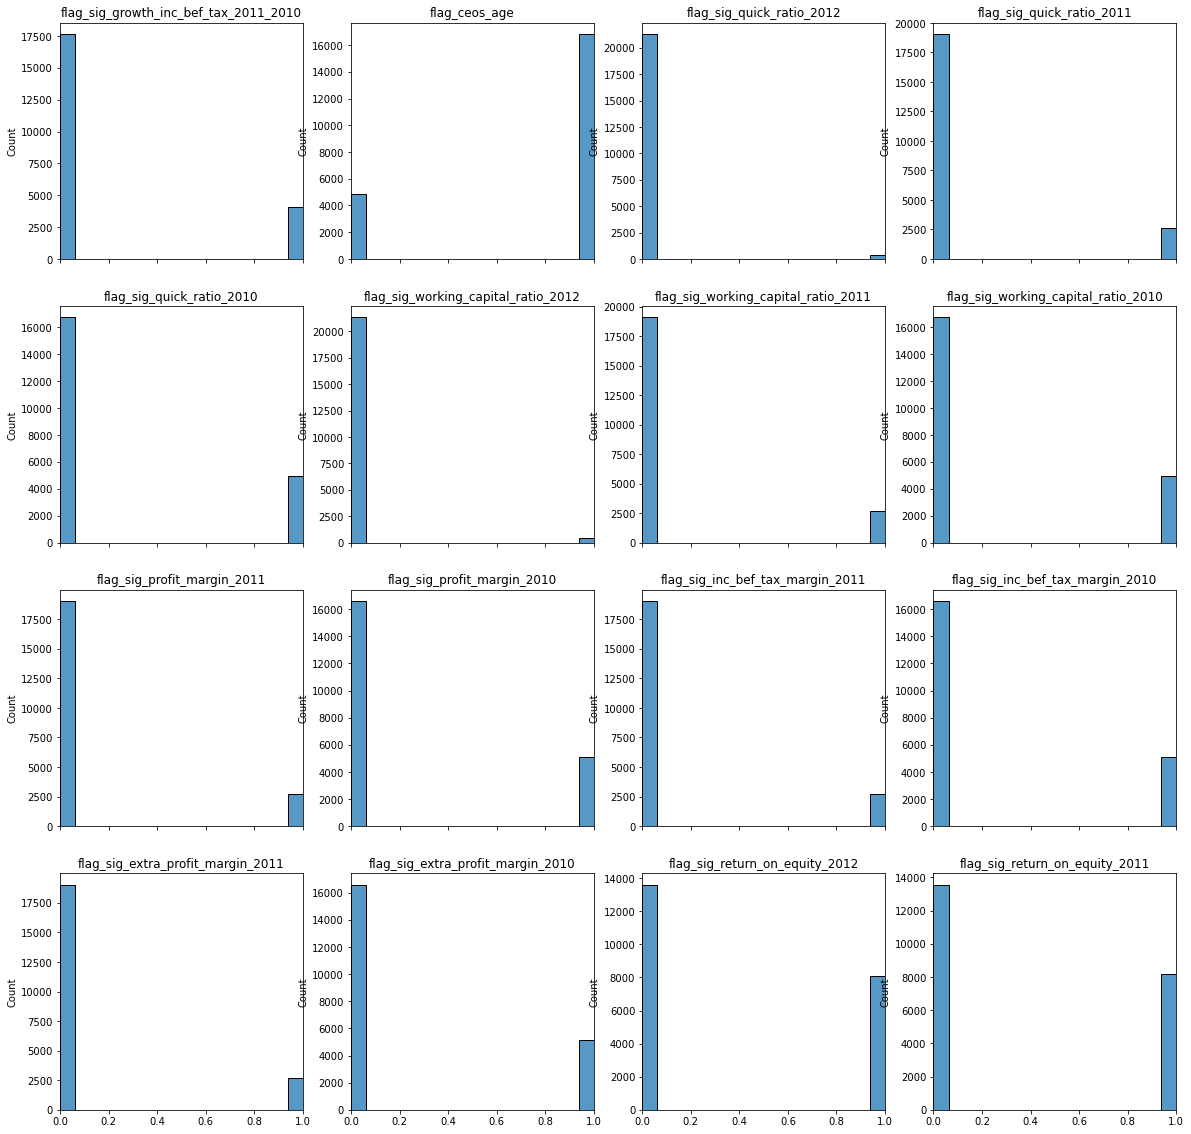

In [94]:
fig, axes = plt.subplots(4, 4, sharex=True, figsize=(20,20))
i = 20
for r in range(4):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=flags_remaining[i]);
        axes[r, c].set_xlim([0,1])
        axes[r, c].set_title(flags_remaining[i])
        axes[r, c].set(xlabel=None)
        i+=1

## Identificando Outliers

- flag high: Outiliers acima do limite superior com base no critério Q3 + 1.5*IQR
- flag low:  Outiliers acima do limite superior com base no critério Q1 - 1.5*IQR

In [95]:
def flag_outliers(table, variable):

    """
    Resumo: Calcula IQR e identifica outilers.
    Entradas:
        table - Tabela de interesse                                                     | tipo: dataframe
        variable - Nome da variável que será analisada                                  | tipo: string
    Saídas:
        table - Dataframe de entrada contendo duas novas colunas: 
                - "flag_high_variable" marcação das observações acima do limite superior
                - "flag_low_variable" marcação das observações abaixo do limite inferior
    """

    # Calculand limites superiores e inferiores
    q1 = table[variable].quantile(0.25)
    q3 = table[variable].quantile(0.75)
    iqr = q3-q1
    limite_sup = q3 + 1.5*iqr
    limite_inf = q1 - 1.5*iqr

    # Marcando colunas com resultados acima do limite superior
    table['flag_high_'+variable] = np.where(table[variable] > limite_sup, 1, 0)

    # Marcando colunas com resultados abaixo do limite inferior
    table['flag_low_'+variable] = np.where(table[variable] < limite_inf, 1, 0)

    return table.reset_index(drop=True)

In [96]:
# Aplicando a função para todas as colunas de numéricas de interesse
features_outliers = features_log + features_logsqrt + features_sig
for feature in features_outliers:
    tb2012 = flag_outliers(table=tb2012, variable=feature)

In [97]:
# Seleciona flags constantes
remover_flag = []
for item in tb2012.columns:
    if ('high' in item or 'low' in item) and tb2012[item].min()==tb2012[item].max():
        remover_flag.append(item)

# Remove flags constantes
tb2012 = tb2012.drop(columns=remover_flag, axis = 0)

# Flags remanescentes
flags_high_low = []
for flag in tb2012.columns:
    if ('high' in flag or 'low' in flag) and (flag not in remover_flag):
        flags_high_low.append(flag)    

## Plotando Gráficos de Flags para Outliers

Objetivo: Notas algum volume de outilers acima do normal para qualquer variável.\
Conclusão: Volume de outliers aparentemente adequado com base no critério utilizado

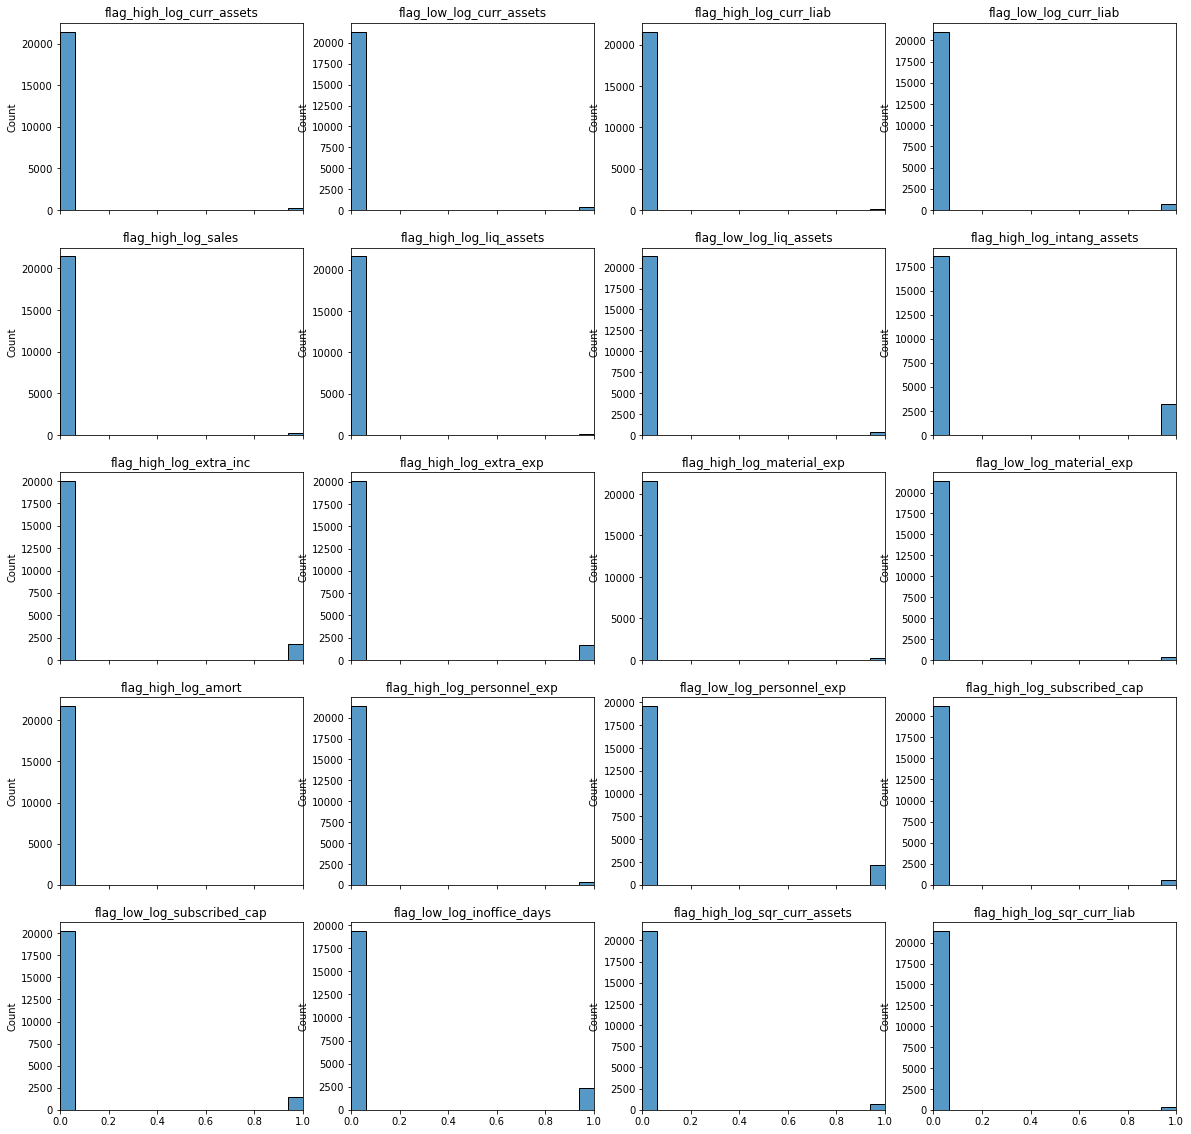

In [98]:
fig, axes = plt.subplots(5, 4, sharex=True, figsize=(20,20))
i = 0
for r in range(5):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=flags_high_low[i]);
        axes[r, c].set_xlim([0,1])
        axes[r, c].set_title(flags_high_low[i])
        axes[r, c].set(xlabel=None)
        i+=1

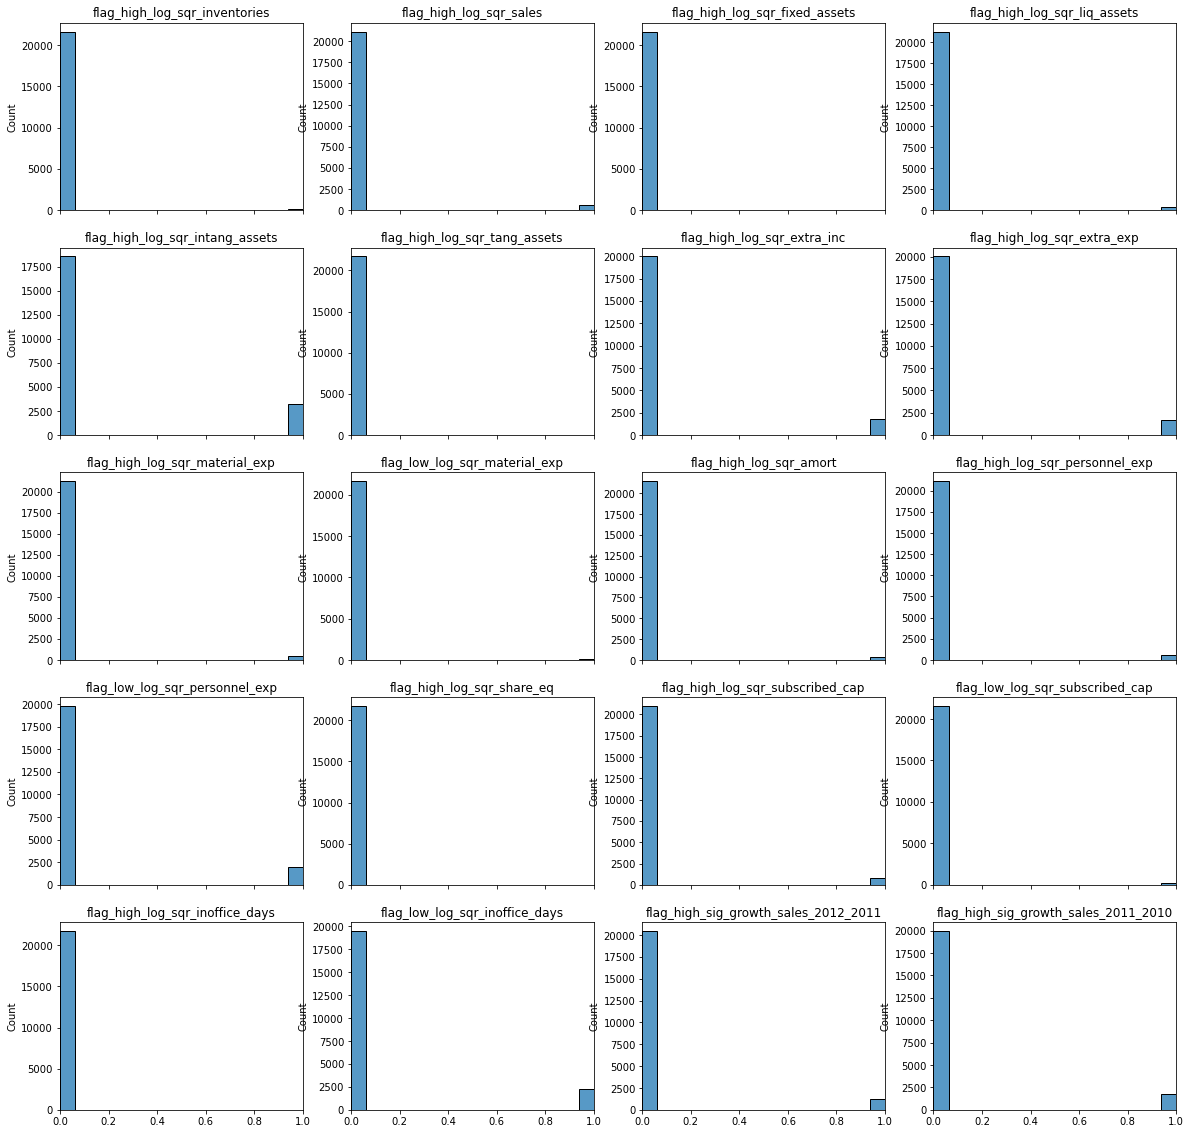

In [99]:
fig, axes = plt.subplots(5, 4, sharex=True, figsize=(20,20))
i = 20
for r in range(5):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=flags_high_low[i]);
        axes[r, c].set_xlim([0,1])
        axes[r, c].set_title(flags_high_low[i])
        axes[r, c].set(xlabel=None)
        i+=1

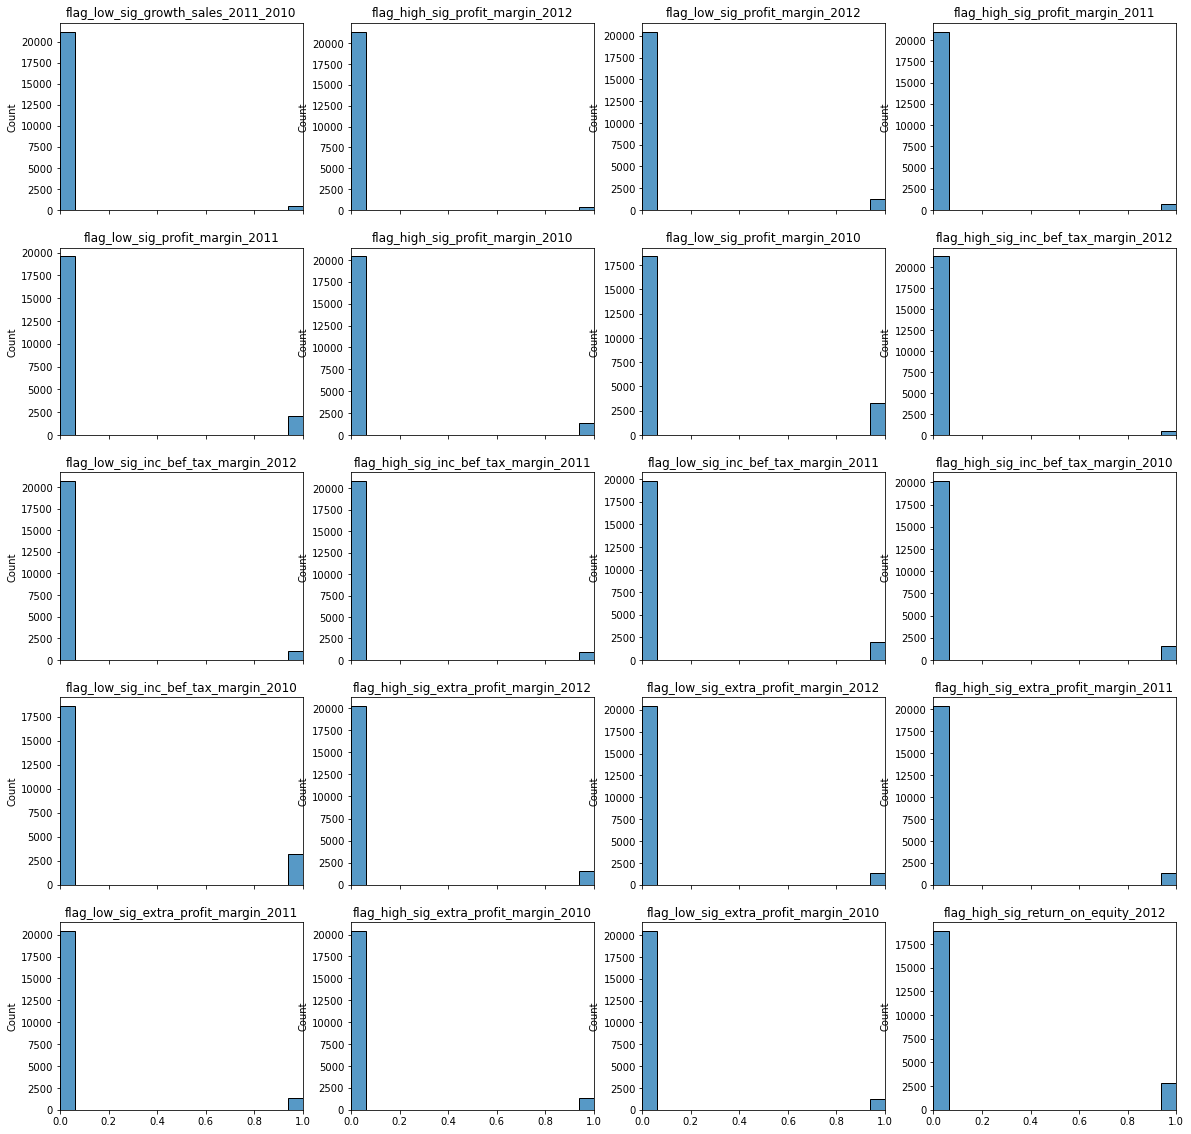

In [100]:
fig, axes = plt.subplots(5, 4, sharex=True, figsize=(20,20))
i = 40
for r in range(5):
    for c in range(4):
        sns.histplot(ax=axes[r, c], data=tb2012, x=flags_high_low[i]);
        axes[r, c].set_xlim([0,1])
        axes[r, c].set_title(flags_high_low[i])
        axes[r, c].set(xlabel=None)
        i+=1

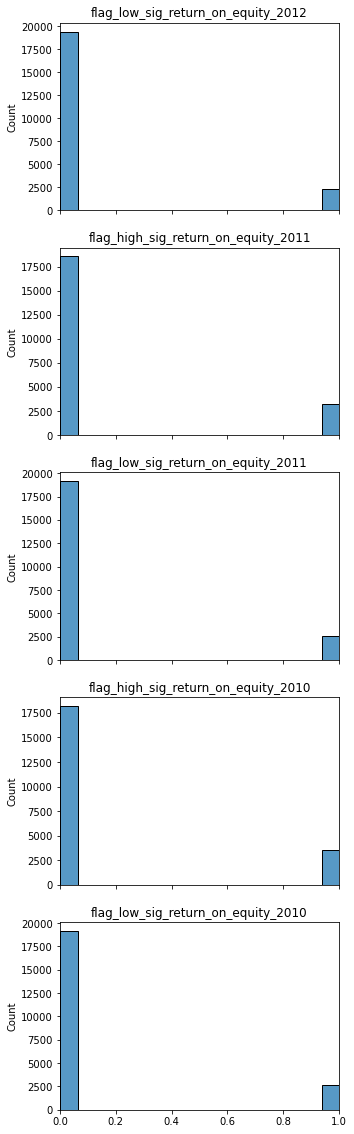

In [101]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(5,20))
i = 60
for r in range(5):
    sns.histplot(ax=axes[r], data=tb2012, x=flags_high_low[i]);
    axes[r].set_xlim([0,1])
    axes[r].set_title(flags_high_low[i])
    axes[r].set(xlabel=None)
    i+=1

In [102]:
# Preenchendo qualquer NA que tenha sobrado com 0
tb2012 = tb2012.fillna(0)

In [103]:
# Verificando tabela final
tb2012

,comp_id,flag_balsheet,flag_balsheet_notfullyear,ceo_count,foreign,female,inoffice_days,origin,nace_main,ind2,...,flag_high_sig_extra_profit_margin_2011,flag_low_sig_extra_profit_margin_2011,flag_high_sig_extra_profit_margin_2010,flag_low_sig_extra_profit_margin_2010,flag_high_sig_return_on_equity_2012,flag_low_sig_return_on_equity_2012,flag_high_sig_return_on_equity_2011,flag_low_sig_return_on_equity_2011,flag_high_sig_return_on_equity_2010,flag_low_sig_return_on_equity_2010
0,1001541,0.0,0.0,1.0,0.0,0.000000,3222.000000,1,5610.0,56.0,...,0,0,0,0,0,0,0,1,0,1
1,1002029,0.0,0.0,2.0,0.0,0.000000,3101.000000,1,2711.0,27.0,...,0,0,0,0,0,0,0,0,1,0
2,1003200,0.0,0.0,2.0,0.0,1.000000,1754.000000,1,5630.0,56.0,...,0,0,0,0,0,0,0,0,0,0
3,1011889,0.0,0.0,1.0,0.0,0.000000,6198.000000,1,5510.0,55.0,...,0,1,0,0,0,0,0,0,0,0
4,1014183,0.0,0.0,1.0,0.0,0.000000,3594.000000,1,5510.0,55.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21712,463885369344,0.0,0.0,1.0,0.0,0.000000,2615.000000,1,4331.0,43.0,...,0,0,0,1,1,0,0,1,0,0
21713,463981969408,0.0,0.0,1.0,0.0,0.000000,7902.000000,1,2822.0,28.0,...,0,0,0,0,0,1,0,0,0,0
21714,464021159936,0.0,0.0,1.0,0.0,0.000000,1221.000000,1,2822.0,28.0,...,0,0,0,0,0,0,0,0,0,0
21715,464044589056,0.0,0.0,1.0,1.0,0.000000,2943.000000,2,3312.0,33.0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
# Salvando tabela em csv
tb2012.to_csv("bisnode_ajustado_completo_2012.csv", sep=',', index = False)